In [1]:
import pandas as pd
import pickle as pickle
import numpy as np
from datetime import datetime
from datetime import date
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
import os
import gc

pd.set_option('display.max_columns', None)

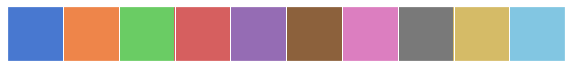

In [2]:
# Background graph style
sns.set(style="darkgrid")
# ==============
# Chouse color
# ==============
sns.palplot(sns.color_palette("muted"))  # show color
sns.set_palette("muted") # for seaborn
colors = sns.color_palette("muted") # for pyplot

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('../../data/raw/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../data/raw/productos.csv
../../data/raw/censo_train.csv
../../data/raw/censo_test.csv
../../data/raw/y_train.csv
../../data/raw/sample_submission.csv
../../data/raw/sunat_train.csv
../../data/raw/se_train.csv
../../data/raw/se_test.csv
../../data/raw/rcc_test.csv
../../data/raw/rcc_train.csv
../../data/raw/interbank20.zip
../../data/raw/sunat_test.csv


In [4]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

### Descripción de los datos
En todos los archivos, la columna "key_value" corresponde a la identificación ofuscada de la persona, pero los ids no son compatibles entre conjuntos de datos (train|test). Es decir, el key_value = 1 de rcc_train no es la misma persona que el key_value = 1 de rcc_test.

    


### RCC_TRAIN
**rcc_[train|test].csv**: historial crediticio
+ codmes: año y mes de la observación
+ condicion: dias de atraso
+ tipo_credito: tipo de credito
+ cod_instit_financiera: codigo de la institución financiera otorgante
+ saldo: monto de línea o adeudado
+ PRODUCTO: tipo de producto, para la descripción cruzar con productos.csv
+ RIESGO_DIRECTO: un indicador ordinal del riesgo de la persona
+ COD_CLASIFICACION_DEUDOR: un indicador categórico del riesgo de la persona

In [5]:
rcc_train = pd.read_csv("../../data/raw/rcc_train.csv").pipe(reduce_mem_usage)

In [9]:
bins = [-1, 0, 10, 20, 30, 60, 90, 180, 360, 720, float("inf")]
rcc_train["condicion_bin"] = pd.cut(rcc_train.condicion, bins)

In [7]:
productos = pd.read_csv("../../data/raw/productos.csv")

In [8]:
productos.columns = ['producto', 'id_producto']

In [10]:
rcc_train = pd.merge(rcc_train, productos, how='left', left_on='PRODUCTO', right_on='id_producto').drop(['PRODUCTO', 'id_producto'], axis=1)

In [18]:
rcc_train.producto.fillna('NA',inplace=True)

In [4]:
y_train = pd.read_csv("../../data/raw/y_train.csv")

In [25]:
rcc_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30391626 entries, 0 to 30391625
Data columns (total 9 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   codmes                    int64  
 1   key_value                 int64  
 2   condicion                 int64  
 3   tipo_credito              int64  
 4   cod_instit_financiera     int64  
 5   saldo                     float64
 6   RIESGO_DIRECTO            int64  
 7   COD_CLASIFICACION_DEUDOR  int64  
 8   producto                  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 2.3+ GB


In [5]:
rcc_train.head()

,codmes,key_value,condicion,tipo_credito,cod_instit_financiera,saldo,PRODUCTO,RIESGO_DIRECTO,COD_CLASIFICACION_DEUDOR
0,201711,4,0,12,33,-0.072601,6,-1,0
1,201711,4,0,12,33,-0.070608,7,-1,0
2,201711,4,0,12,61,-0.052054,5,-1,0
3,201711,4,0,11,32,-0.072456,8,1,0
4,201711,4,0,12,61,-0.057877,0,1,0


In [13]:
rcc_train.describe().T # numerical data

,count,mean,std,min,25%,50%,75%,max
codmes,30391626.0,2.017257e+05,37.130381,201703.000000,201706.000000,201709.000000,201712.000000,201802.000000
key_value,30391626.0,1.730234e+05,101436.547446,0.000000,84838.000000,172388.000000,259210.000000,358486.000000
condicion,30391626.0,1.438200e+01,186.351144,0.000000,0.000000,0.000000,0.000000,9999.000000
tipo_credito,30391626.0,1.159850e+01,7.581905,6.000000,11.000000,11.000000,11.000000,99.000000
cod_instit_financiera,30391626.0,2.143093e+01,17.695956,0.000000,3.000000,18.000000,34.000000,108.000000
saldo,30391626.0,-3.838222e-18,1.000000,-0.072892,-0.072332,-0.063934,-0.033075,1891.015714
PRODUCTO,30391626.0,1.923337e+01,59.513419,0.000000,1.000000,3.000000,8.000000,255.000000
RIESGO_DIRECTO,30391626.0,-4.401513e-01,0.906344,-1.000000,-1.000000,-1.000000,1.000000,5.000000
COD_CLASIFICACION_DEUDOR,30391626.0,1.112843e-01,0.583196,0.000000,0.000000,0.000000,0.000000,5.000000


In [14]:
print(rcc_train.nunique())

codmes                          12
key_value                   358487
condicion                     7245
tipo_credito                     8
cod_instit_financiera          109
saldo                       190285
PRODUCTO                        42
RIESGO_DIRECTO                   5
COD_CLASIFICACION_DEUDOR         6
dtype: int64


In [15]:
print(rcc_train.isnull().sum())

codmes                      0
key_value                   0
condicion                   0
tipo_credito                0
cod_instit_financiera       0
saldo                       0
PRODUCTO                    0
RIESGO_DIRECTO              0
COD_CLASIFICACION_DEUDOR    0
dtype: int64


### codmes y key_value

In [16]:
pd.DataFrame([rcc_train.groupby('codmes').key_value.count(), rcc_train.groupby('codmes').key_value.nunique()])

codmes,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802
key_value,2299337,2341813,2365299,2407525,2444190,2475888,2524942,2551045,2582235,2549039,2599133,3251180
key_value,271195,274087,277157,279899,284332,287315,289606,293824,296166,294880,294427,358487


+ el numero de registro por mes no coincide con el numero unico de key value, por lo cual hay mas de un registro por key value cada mes
+ hay un registro por cada producto de cada key_value

In [20]:
rcc_train[rcc_train.key_value.isin([0])].sort_values(['codmes','key_value']).head(20)

,codmes,key_value,condicion,tipo_credito,cod_instit_financiera,saldo,PRODUCTO,RIESGO_DIRECTO,COD_CLASIFICACION_DEUDOR
29617453,201703,0,0,11,11,-0.072814,1,-1,0
29617454,201703,0,0,11,11,-0.038181,2,-1,0
29617455,201703,0,0,11,11,-0.041831,3,-1,0
29617456,201703,0,0,11,11,-0.069253,8,1,0
24792965,201704,0,0,11,11,-0.044653,3,-1,0
24792966,201704,0,0,11,11,-0.066431,8,1,0
24792967,201704,0,0,11,11,-0.072556,1,-1,0
24792968,201704,0,0,11,11,-0.038181,2,-1,0
24792969,201704,0,0,11,11,-0.072814,255,-1,0
8272357,201705,0,0,11,11,-0.072814,255,-1,0


In [7]:
rcc_agg = rcc_train.groupby('codmes').key_value.nunique().reset_index()

In [8]:
rcc_agg

,codmes,key_value
0,201703,271195
1,201704,274087
2,201705,277157
3,201706,279899
4,201707,284332
5,201708,287315
6,201709,289606
7,201710,293824
8,201711,296166
9,201712,294880


In [9]:
rcc_agg.key_value.diff()

0         NaN
1      2892.0
2      3070.0
3      2742.0
4      4433.0
5      2983.0
6      2291.0
7      4218.0
8      2342.0
9     -1286.0
10     -453.0
11    64060.0
Name: key_value, dtype: float64

+ el numero de clientes varia mes a mes
+ el mes 201802, es el mes que supuestamente tenemos el target y todas las variables historicas tienen que construirse de ese mes para atras
+ En el ultimo mes se incorporo 64k clientes netos, por lo cual hay como minimo esa cantidad de clientes que no se deberia incorporar en el universo a modelar porque no se tiene historia suficiente de lso mismos
+ Se deberia crear una variable donde se indeque los key_values que se dan de baja en los diferentes periodos

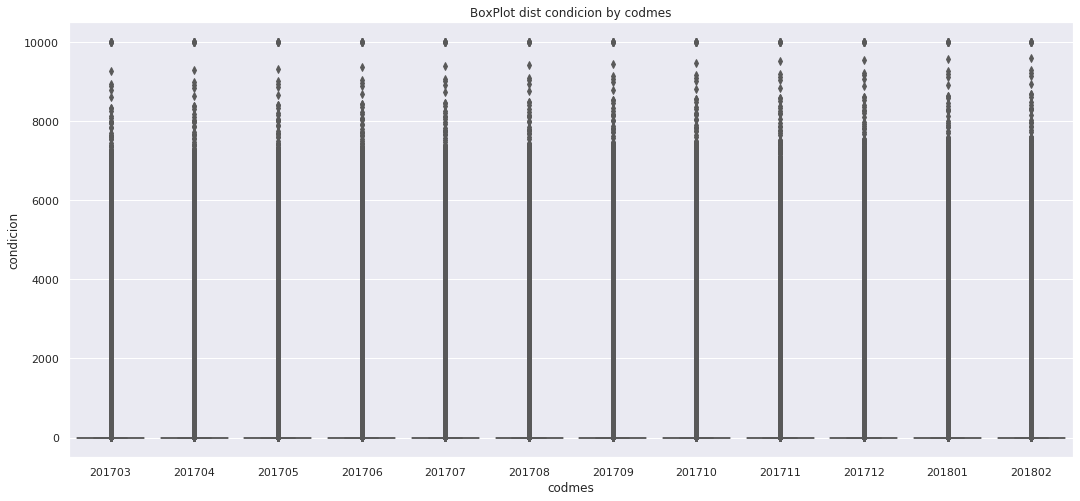

In [25]:
# ====================
#  Boxplot
# ====================
plt.figure(figsize=(18, 8))
ax = sns.boxplot(x='codmes', y="condicion", 
                 #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_train) # DataFrame, array, or list of arrays, optional
ax.set_title("BoxPlot dist condicion by codmes")
# Tweak the visual presentation
# ax.xaxis.grid(True)
ax.yaxis.grid(True)
pass

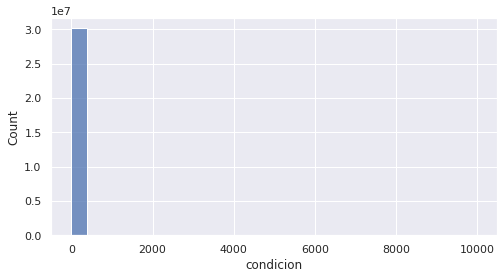

In [81]:
plt.figure(figsize=(8, 4))
sns.set(style="darkgrid")
sns.histplot(data=rcc_train, x="condicion")
pass

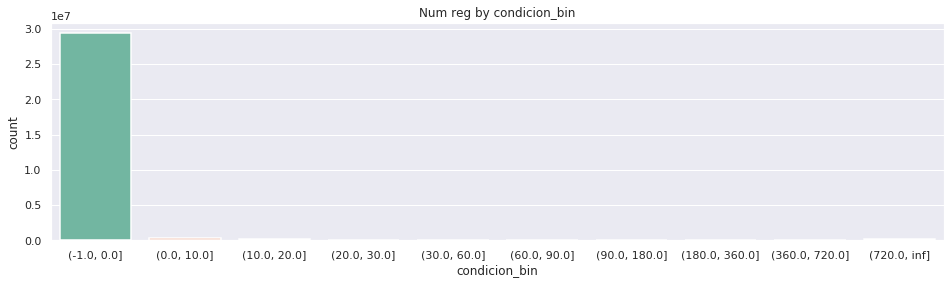

In [22]:
plt.figure(figsize=(16, 4))
ax = sns.countplot(x="condicion_bin",linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_train).set_title("Num reg by condicion_bin")
pass

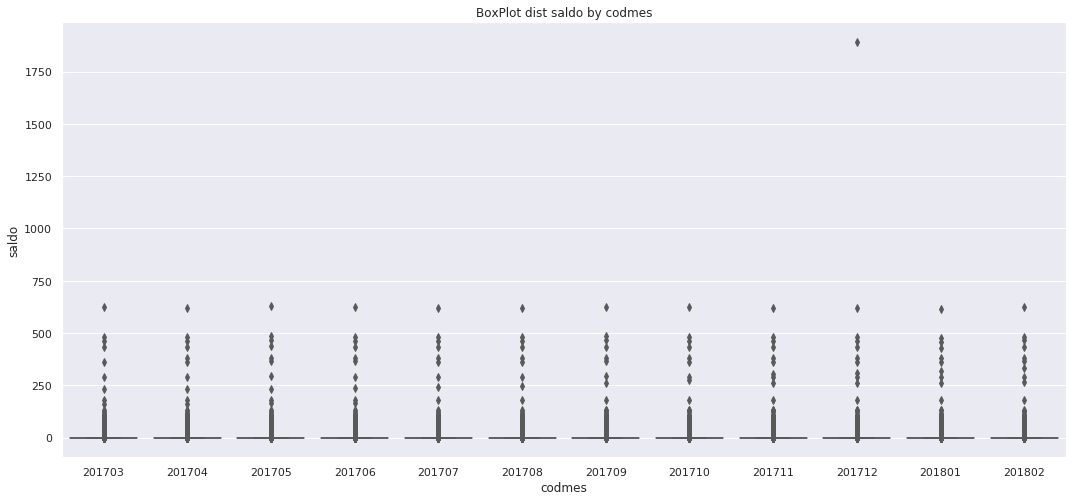

In [26]:
# ====================
#  Boxplot
# ====================
plt.figure(figsize=(18, 8))
ax = sns.boxplot(x='codmes', y="saldo", 
                 #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_train) # DataFrame, array, or list of arrays, optional
ax.set_title("BoxPlot dist saldo by codmes")
# Tweak the visual presentation
# ax.xaxis.grid(True)
ax.yaxis.grid(True)
pass

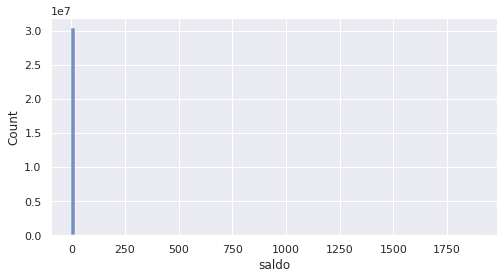

In [54]:
plt.figure(figsize=(8, 4))
sns.set(style="darkgrid")
sns.histplot(data=rcc_train, x="saldo", bins=100)
pass

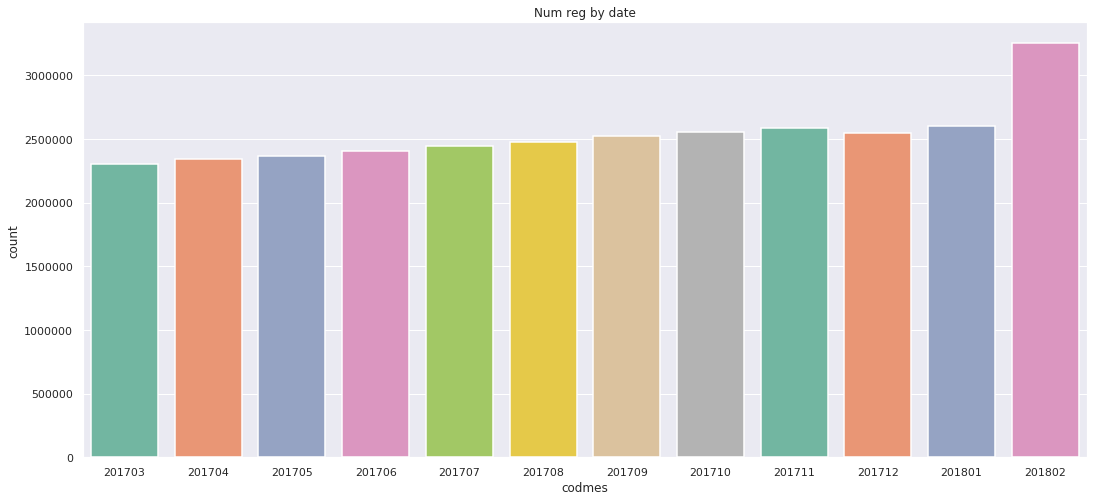

In [52]:
plt.figure(figsize=(18, 8))
ax = sns.countplot(x="codmes",linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_train).set_title("Num reg by date")
pass

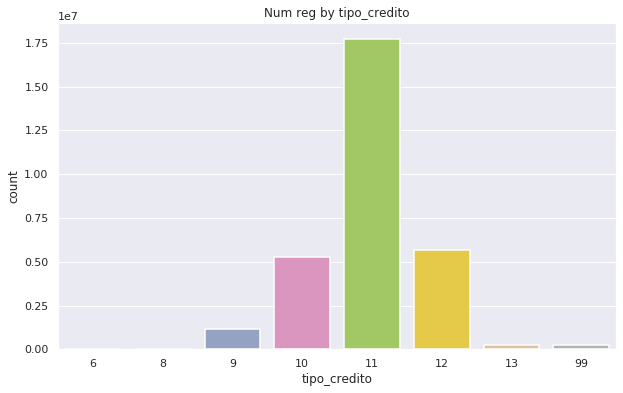

In [56]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="tipo_credito",linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_train).set_title("Num reg by tipo_credito")
pass

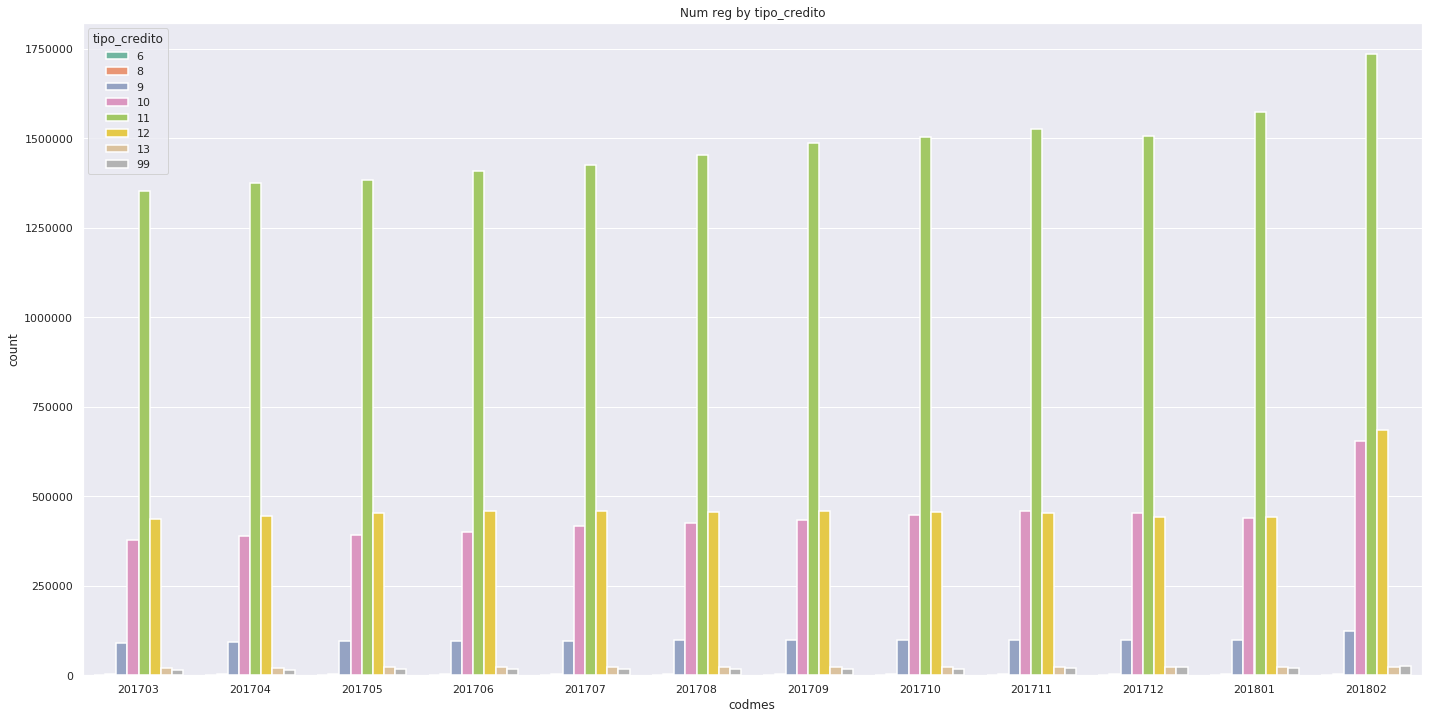

In [60]:
plt.figure(figsize=(24, 12))
ax = sns.countplot(x="codmes",linewidth=1.5,hue="tipo_credito",
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_train).set_title("Num reg by tipo_credito")
pass

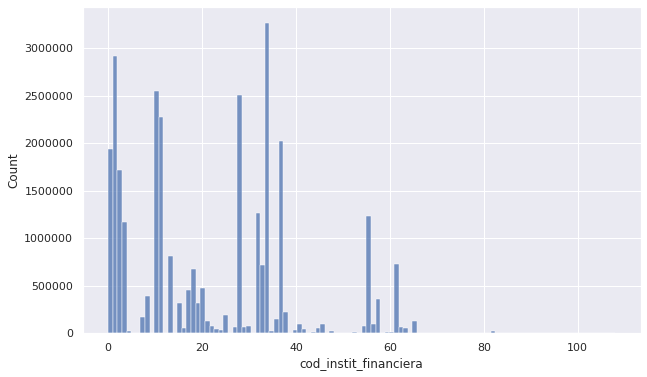

In [65]:
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
sns.histplot(data=rcc_train, x="cod_instit_financiera", bins=110)
pass

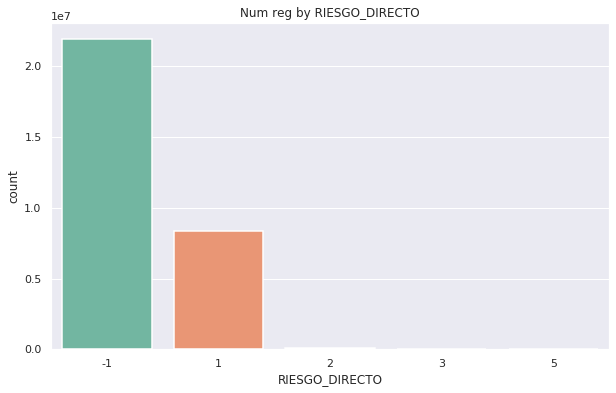

In [72]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="RIESGO_DIRECTO",linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_train).set_title("Num reg by RIESGO_DIRECTO")
pass

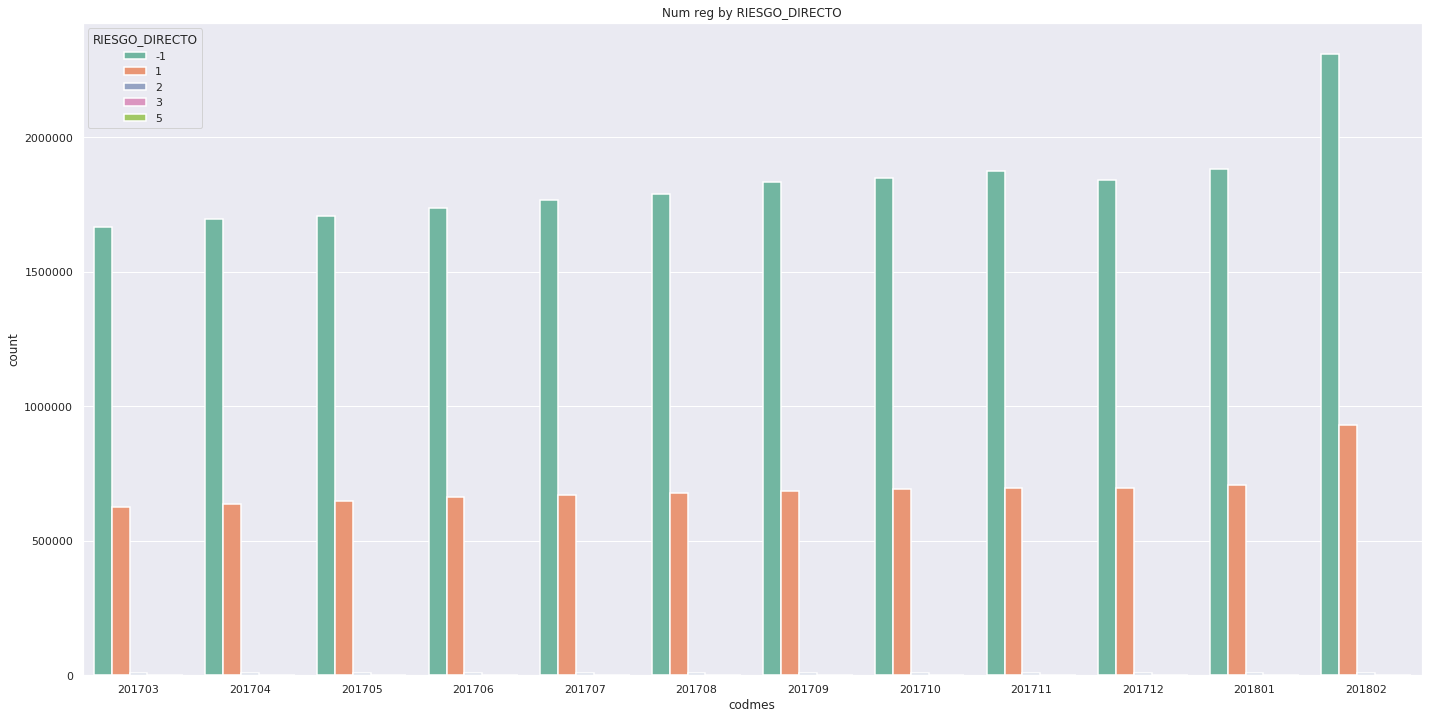

In [73]:
plt.figure(figsize=(24, 12))
ax = sns.countplot(x="codmes",linewidth=1.5,hue="RIESGO_DIRECTO", palette="Set2", data=rcc_train).set_title("Num reg by RIESGO_DIRECTO")
pass

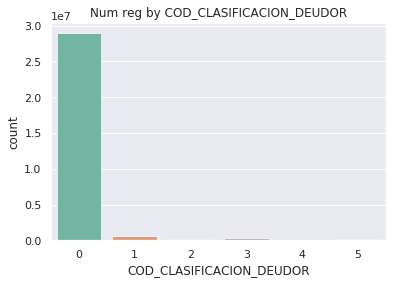

In [75]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="COD_CLASIFICACION_DEUDOR",linewidth=.7,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_train).set_title("Num reg by COD_CLASIFICACION_DEUDOR")
pass

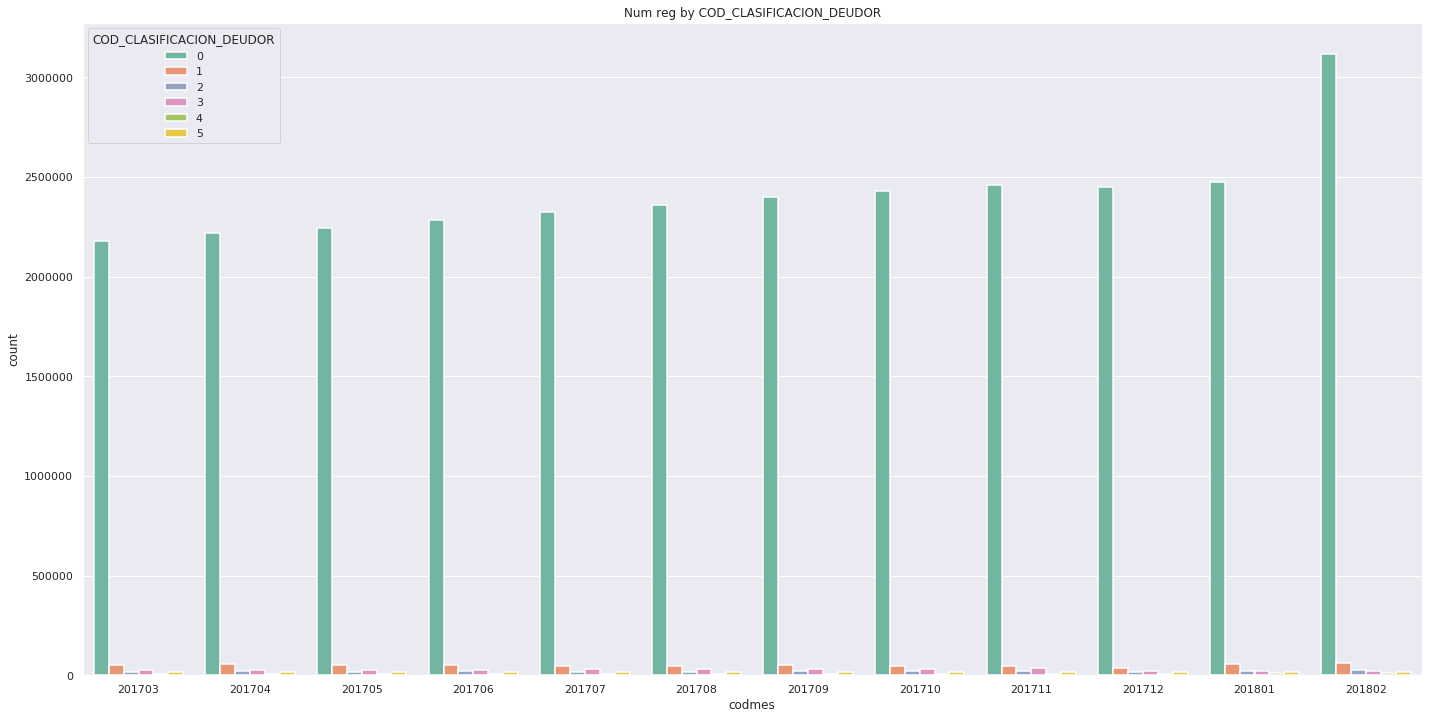

In [76]:
plt.figure(figsize=(24, 12))
ax = sns.countplot(x="codmes",linewidth=1.5,hue="COD_CLASIFICACION_DEUDOR",
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_train).set_title("Num reg by COD_CLASIFICACION_DEUDOR")
pass

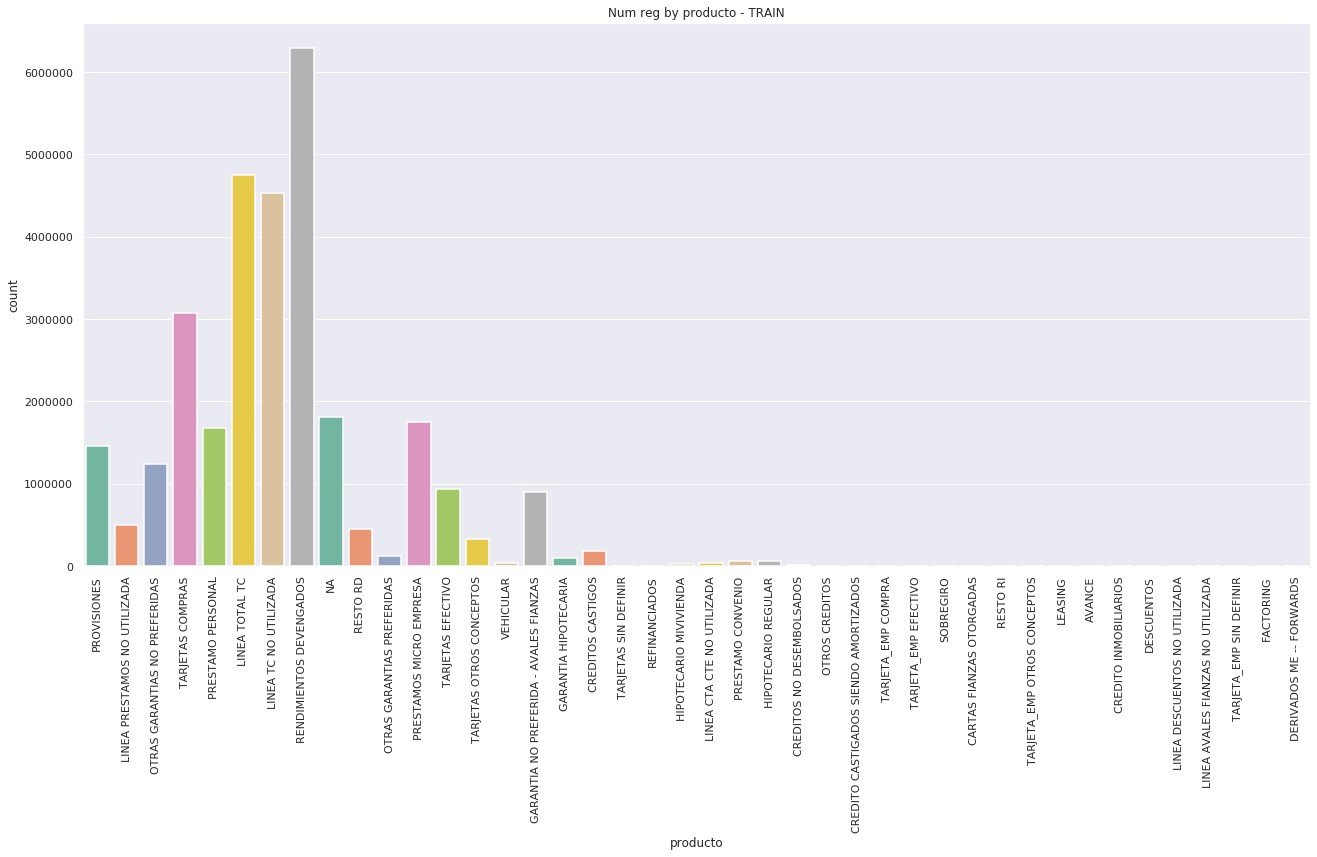

In [19]:
plt.figure(figsize=(22, 10))
ax = sns.countplot(x="producto",linewidth=1.5, palette="Set2", data=rcc_train, order=rcc_train.producto.unique().tolist().sort()).set_title("Num reg by producto - TRAIN")
plt.xticks(rotation=90)
pass

In [35]:
gc.collect()

8897

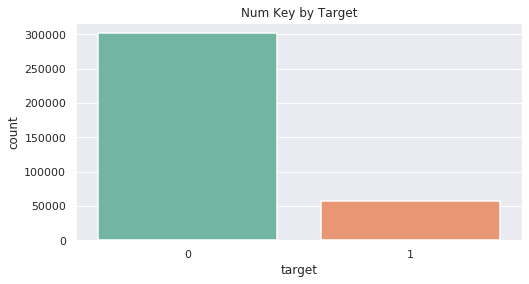

In [34]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(x="target",linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=y_train).set_title("Num Key by Target")
pass

### RCC_TEST

In [10]:
rcc_test = pd.read_csv("../../data/raw/rcc_test.csv").pipe(reduce_mem_usage)

In [28]:
rcc_test["condicion_bin"] = pd.cut(rcc_test.condicion, bins)

In [22]:
rcc_test = pd.merge(rcc_test, productos, how='left', left_on='PRODUCTO', right_on='id_producto').drop(['PRODUCTO', 'id_producto'], axis=1)

In [23]:
rcc_test.producto.fillna('NA',inplace=True)

In [37]:
rcc_test.head()

,codmes,key_value,condicion,tipo_credito,cod_instit_financiera,saldo,RIESGO_DIRECTO,COD_CLASIFICACION_DEUDOR,producto
0,201811,1103,0,10,28.0,-0.072825,-1,0,RENDIMIENTOS DEVENGADOS
1,201811,1103,0,10,28.0,-0.072881,-1,0,OTRAS GARANTIAS NO PREFERIDAS
2,201811,1103,0,10,28.0,-0.065838,1,0,PRESTAMOS MICRO EMPRESA
3,201811,1103,0,10,28.0,-0.072881,-1,0,NA
4,201811,1104,0,13,3.0,0.583493,1,0,HIPOTECARIO MIVIVIENDA


In [38]:
rcc_test.describe().T # numerical data

,count,mean,std,min,25%,50%,75%,max
codmes,34351754.0,201825.785648,37.187570,201803.000000,201806.000000,201809.000000,201812.000000,201902.000000
key_value,34351754.0,189390.533912,111620.679985,0.000000,92110.000000,187760.500000,284291.000000,396665.000000
condicion,34351754.0,17.497493,207.891918,0.000000,0.000000,0.000000,0.000000,9999.000000
tipo_credito,34351754.0,11.694141,8.182281,6.000000,11.000000,11.000000,11.000000,99.000000
cod_instit_financiera,34351420.0,21.798270,17.826888,0.000000,7.000000,18.000000,34.000000,108.000000
saldo,34351754.0,0.001114,1.155592,-0.072892,-0.072377,-0.064102,-0.032067,1748.834149
RIESGO_DIRECTO,34351754.0,-0.439367,0.907892,-1.000000,-1.000000,-1.000000,1.000000,5.000000
COD_CLASIFICACION_DEUDOR,34351754.0,0.114218,0.612602,0.000000,0.000000,0.000000,0.000000,5.000000


In [39]:
print(rcc_test.nunique())

codmes                          12
key_value                   396666
condicion                     7806
tipo_credito                     9
cod_instit_financiera           96
saldo                       207996
RIESGO_DIRECTO                   5
COD_CLASIFICACION_DEUDOR         6
producto                        42
dtype: int64


In [40]:
print(rcc_test.isnull().sum())

codmes                        0
key_value                     0
condicion                     0
tipo_credito                  0
cod_instit_financiera       334
saldo                         0
RIESGO_DIRECTO                0
COD_CLASIFICACION_DEUDOR      0
producto                      0
dtype: int64


### codmes y key_value

In [11]:
rcc_agg = rcc_test.groupby('codmes').key_value.nunique().reset_index()

In [12]:
rcc_agg

,codmes,key_value
0,201803,304407
1,201804,307786
2,201805,311221
3,201806,314598
4,201807,319240
5,201808,321742
6,201809,323546
7,201810,327975
8,201811,329841
9,201812,327683


In [13]:
rcc_agg.key_value.diff()

0         NaN
1      3379.0
2      3435.0
3      3377.0
4      4642.0
5      2502.0
6      1804.0
7      4429.0
8      1866.0
9     -2158.0
10    -1236.0
11    70219.0
Name: key_value, dtype: float64

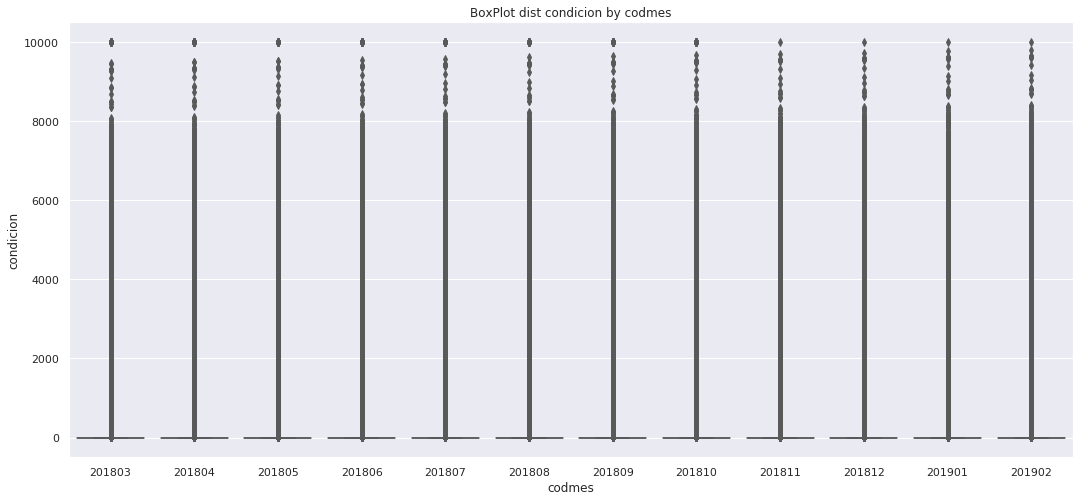

In [47]:
# ====================
#  Boxplot
# ====================
plt.figure(figsize=(18, 8))
ax = sns.boxplot(x='codmes', y="condicion", 
                 #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_test) # DataFrame, array, or list of arrays, optional
ax.set_title("BoxPlot dist condicion by codmes")
# Tweak the visual presentation
# ax.xaxis.grid(True)
ax.yaxis.grid(True)
pass

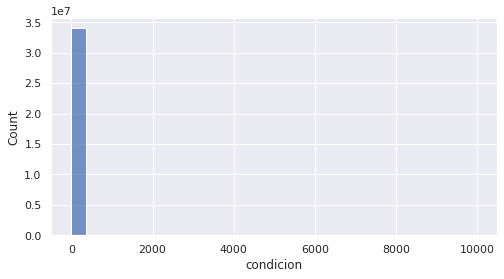

In [48]:
plt.figure(figsize=(8, 4))
sns.set(style="darkgrid")
sns.histplot(data=rcc_test, x="condicion")
pass

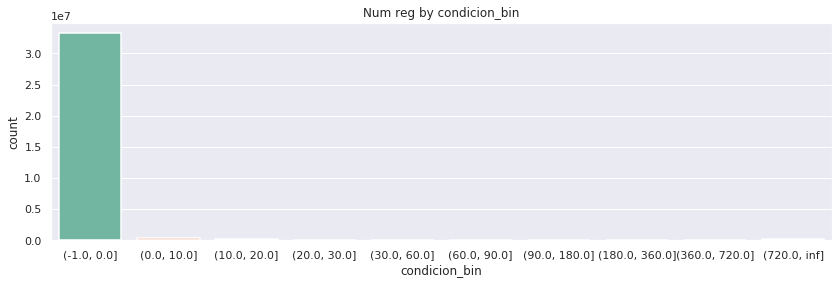

In [29]:
plt.figure(figsize=(14, 4))
ax = sns.countplot(x="condicion_bin",linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_test).set_title("Num reg by condicion_bin")
pass

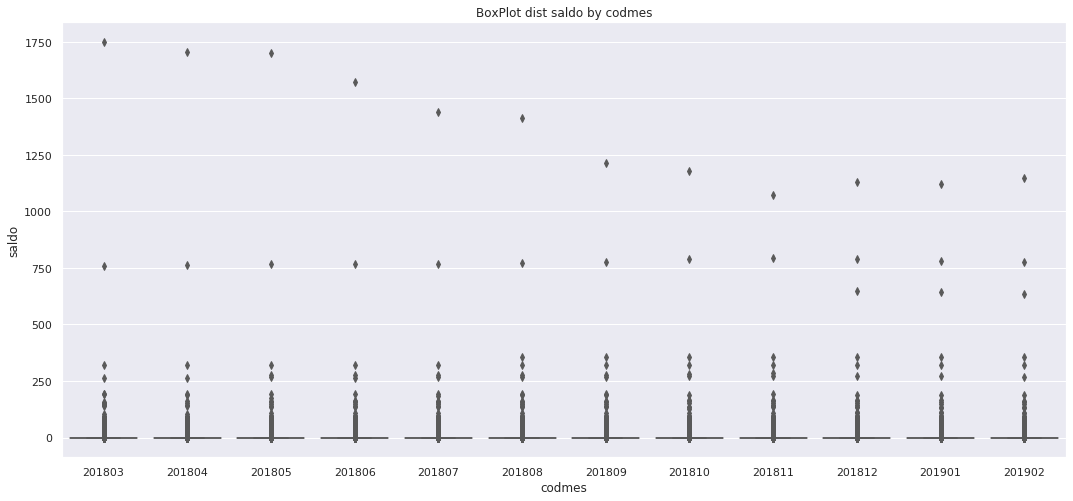

In [49]:
# ====================
#  Boxplot
# ====================
plt.figure(figsize=(18, 8))
ax = sns.boxplot(x='codmes', y="saldo", 
                 #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_test) # DataFrame, array, or list of arrays, optional
ax.set_title("BoxPlot dist saldo by codmes")
# Tweak the visual presentation
# ax.xaxis.grid(True)
ax.yaxis.grid(True)
pass

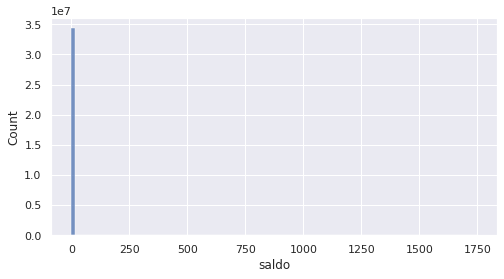

In [50]:
plt.figure(figsize=(8, 4))
sns.set(style="darkgrid")
sns.histplot(data=rcc_test, x="saldo", bins=100)
pass

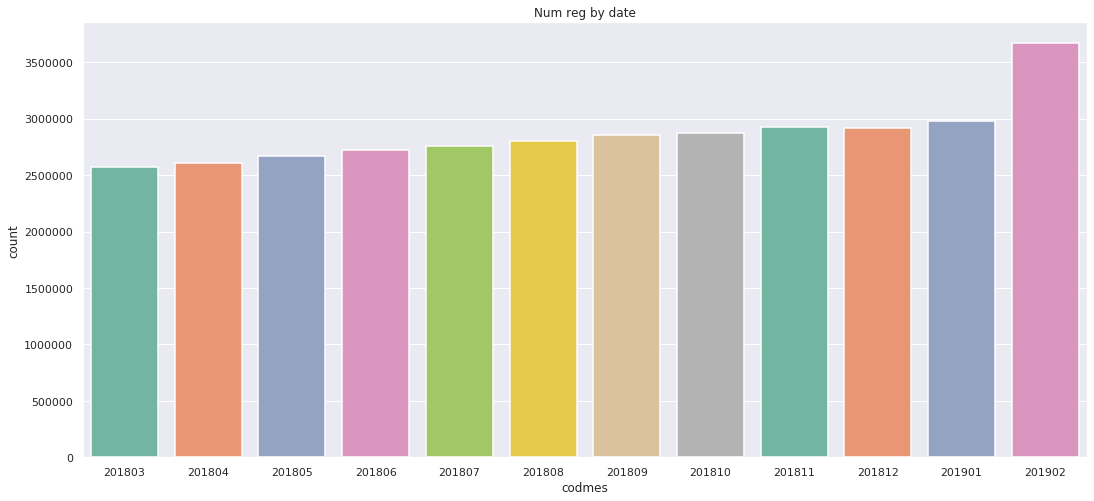

In [53]:
plt.figure(figsize=(18, 8))
ax = sns.countplot(x="codmes",          linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_test).set_title("Num reg by date")
pass

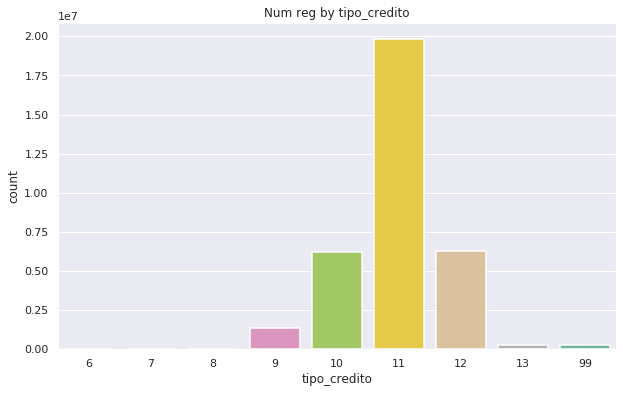

In [61]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="tipo_credito",linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_test).set_title("Num reg by tipo_credito")
pass

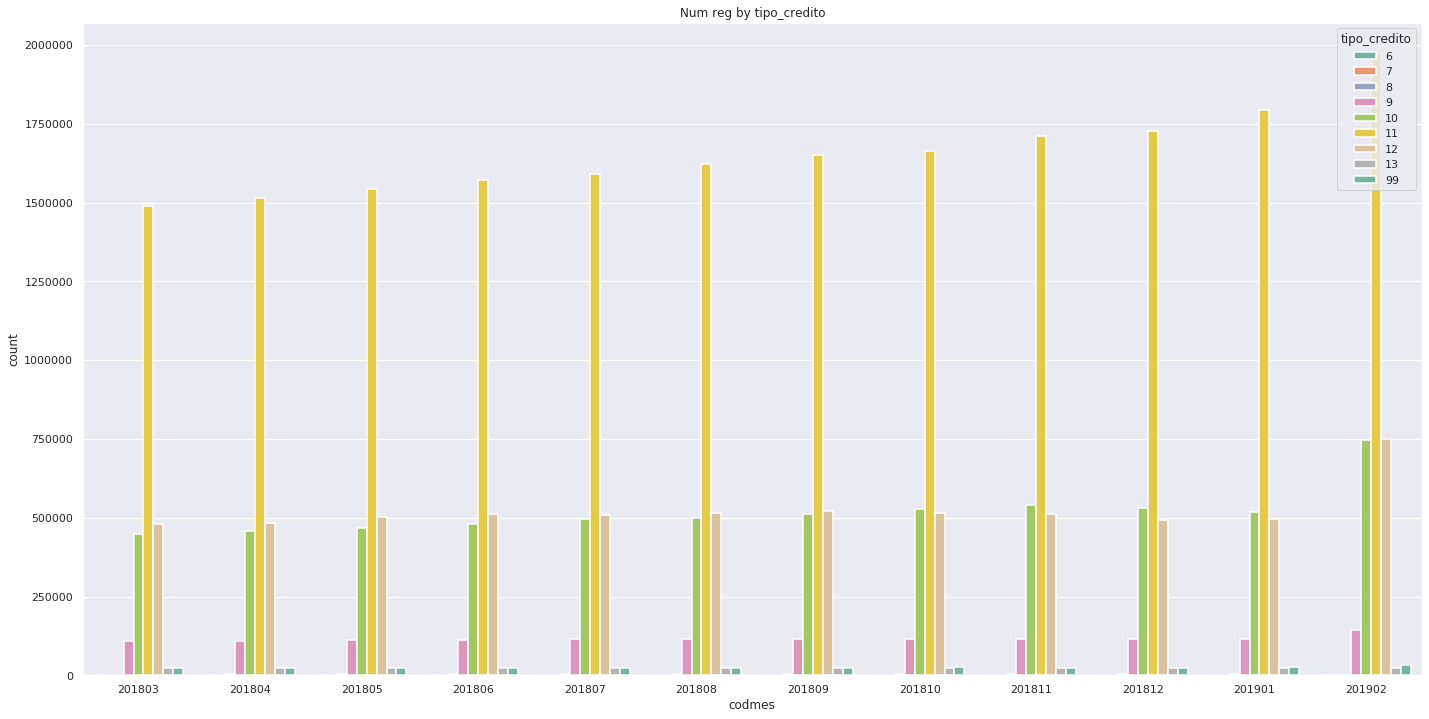

In [62]:
plt.figure(figsize=(24, 12))
ax = sns.countplot(x="codmes",linewidth=1.5,hue="tipo_credito",
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_test).set_title("Num reg by tipo_credito")
pass

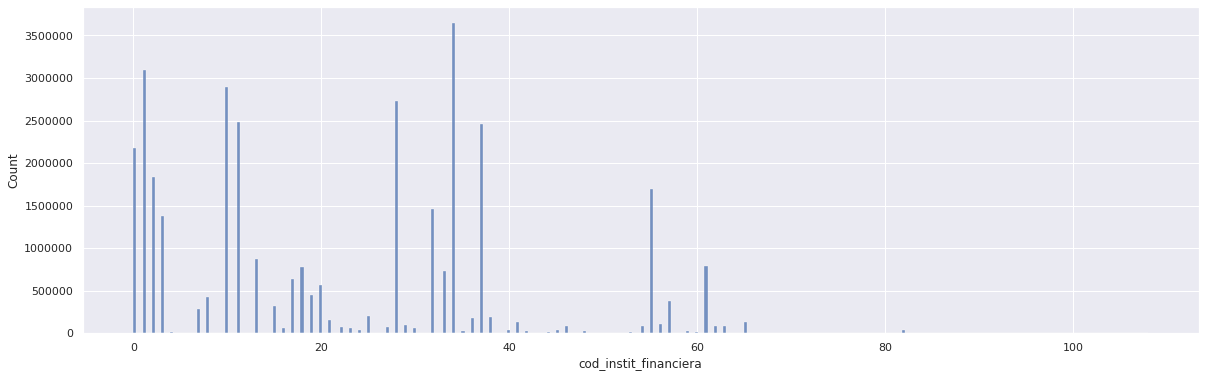

In [68]:
plt.figure(figsize=(20, 6))
sns.set(style="darkgrid")
sns.histplot(data=rcc_test, x="cod_instit_financiera", bins=334)
pass

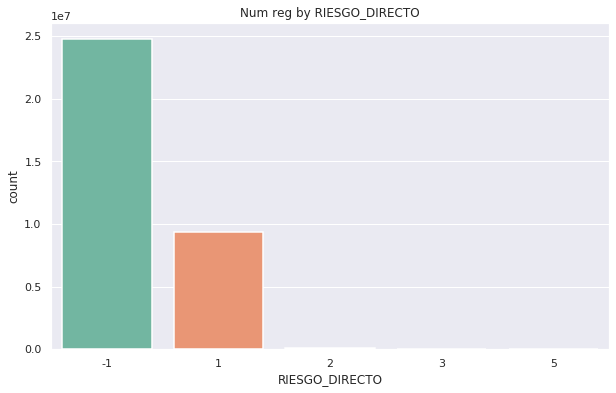

In [69]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="RIESGO_DIRECTO",linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_test).set_title("Num reg by RIESGO_DIRECTO")
pass

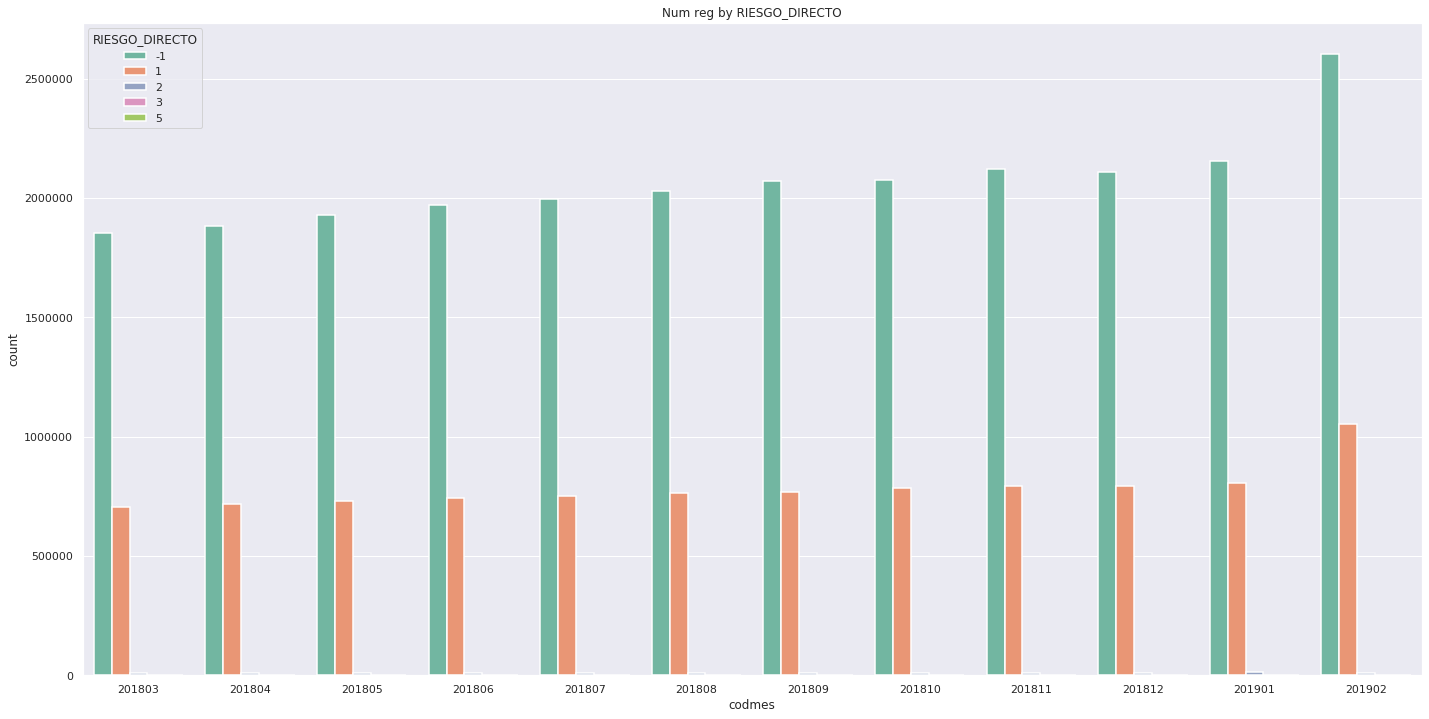

In [71]:
plt.figure(figsize=(24, 12))
ax = sns.countplot(x="codmes",linewidth=1.5,hue="RIESGO_DIRECTO",
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_test).set_title("Num reg by RIESGO_DIRECTO")
pass

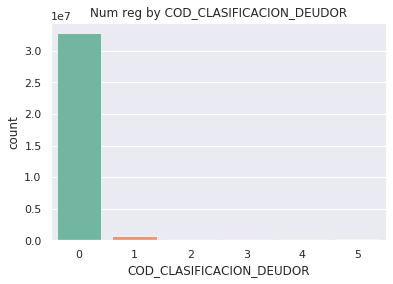

In [77]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="COD_CLASIFICACION_DEUDOR",linewidth=.7,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_test).set_title("Num reg by COD_CLASIFICACION_DEUDOR")
pass

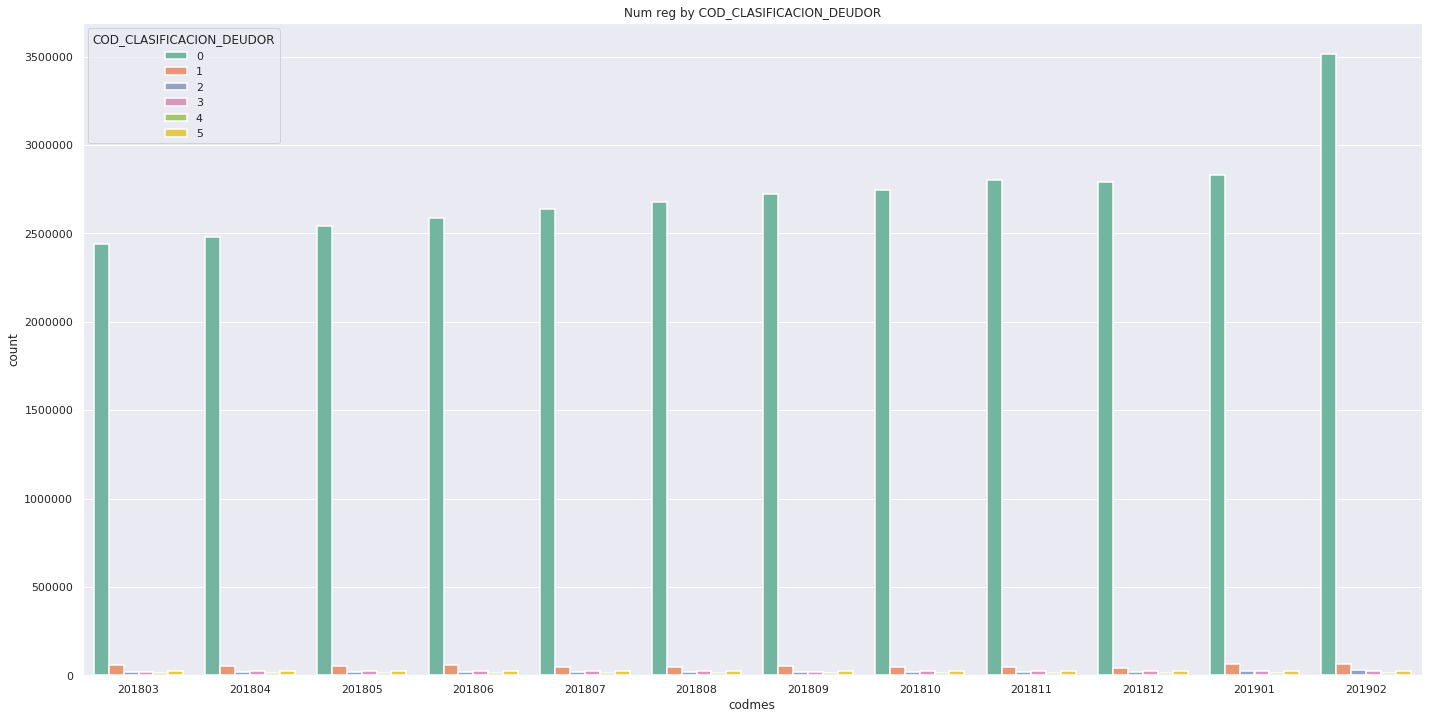

In [78]:
plt.figure(figsize=(24, 12))
ax = sns.countplot(x="codmes",linewidth=1.5,hue="COD_CLASIFICACION_DEUDOR",
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rcc_test).set_title("Num reg by COD_CLASIFICACION_DEUDOR")
pass

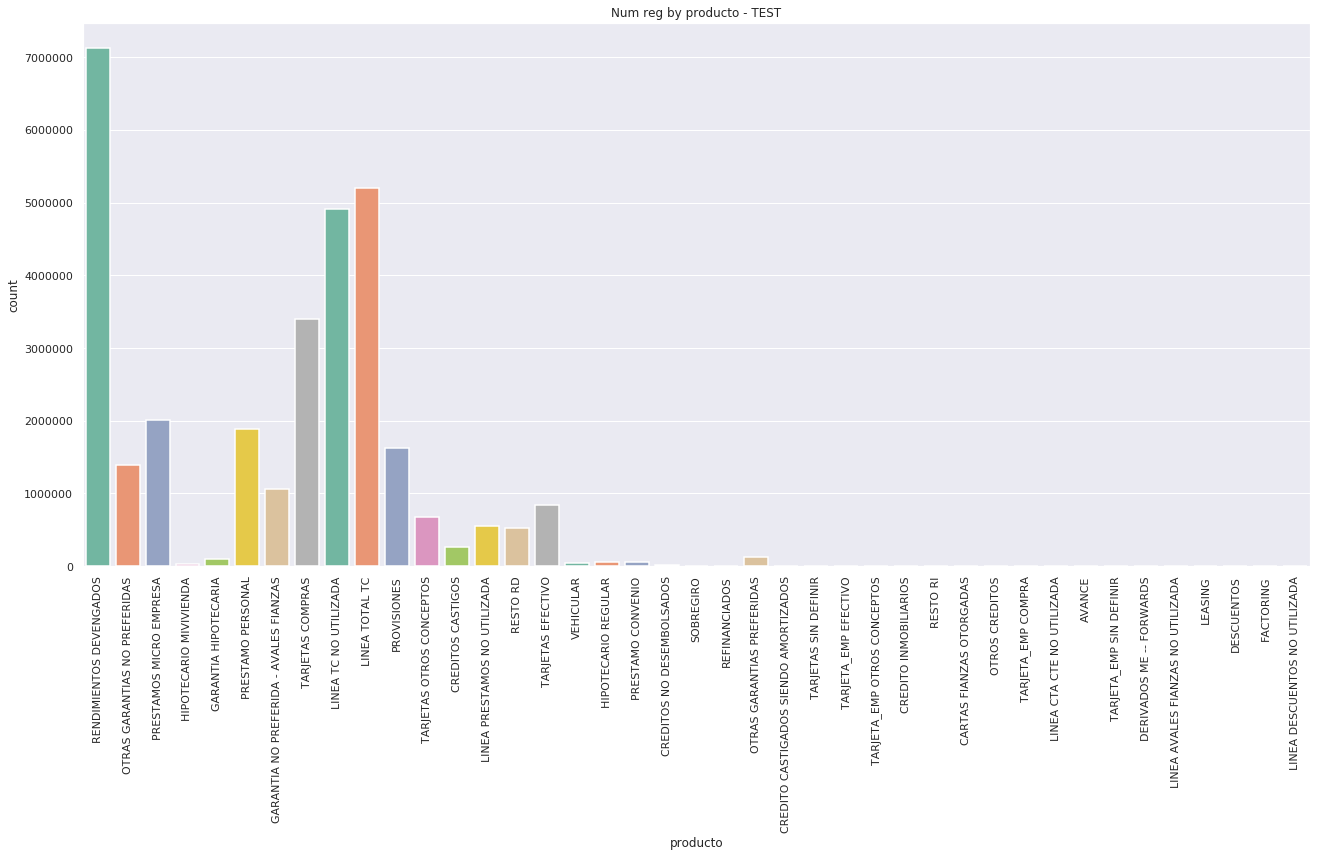

In [31]:
plt.figure(figsize=(22, 10))
ax = sns.countplot(x="producto",linewidth=1.5, palette="Set2", data=rcc_test, order=rcc_test.producto.unique().tolist().sort()).set_title("Num reg by producto - TEST")
plt.xticks(rotation=90)
pass

In [36]:
gc.collect()

20

### SE_TRAIN
**se_[train|test].csv** : información socio-económica

+ edad: edad.
+ sexo: sexo.
+ est_cvl: estado civil.
+ sit_lab: situación laboral.
+ cod_ocu: código de ocupación.
+ ctd_hijos: cantidad de hijos.
+ flg_sin_email: tiene o no email.
+ ctd_veh: cantidad de vehículos.
+ cod_ubi: código ubigeo.
+ lgr_vot: lugar de votación.
+ prv: provincia.
+ dto: departamento.
+ rgn: region.
+ tip_lvledu: tipo de nivel educativo.


In [2]:
se_train = pd.read_csv("../../data/raw/se_train.csv")

In [5]:
se_train = pd.merge(se_train, y_train, how='inner', on='key_value')

In [6]:
se_train.shape

(358428, 16)

In [ ]:
se_train = se_train[se_train.key_value.isin(rcc_train.key_value.unique().tolist())]

In [53]:
se_train.shape

(358428, 15)

In [8]:
se_train.head()

,key_value,edad,sexo,est_cvl,sit_lab,cod_ocu,ctd_hijos,flg_sin_email,ctd_veh,cod_ubi,lgr_vot,prv,dto,rgn,tip_lvledu,target
0,0,-0.983651,1,4,2,22,0.0,1,0.0,-0.070167,17,47,687,4,0,0
1,1,0.000953,1,4,1,22,0.0,1,1.0,-0.738566,10,186,849,6,0,0
2,2,0.531124,0,4,1,22,0.0,1,0.0,-0.297248,15,84,1405,1,7,0
3,3,-1.135129,0,4,1,22,0.0,1,0.0,-1.203435,4,9,977,6,7,0
4,4,-1.438084,0,4,1,22,0.0,1,0.0,0.043424,18,111,391,3,0,1


In [55]:
se_train.describe().T

,count,mean,std,min,25%,50%,75%,max
key_value,358428.0,1.792406e+05,103488.269407,0.000000,89614.750000,179239.500000,268867.250000,358486.000000
edad,354663.0,3.493983e-17,1.000001,-2.422688,-0.832174,-0.150525,0.682602,5.302666
sexo,358428.0,4.684539e-01,0.519817,0.000000,0.000000,0.000000,1.000000,3.000000
est_cvl,358428.0,3.422194e+00,1.379420,0.000000,4.000000,4.000000,4.000000,5.000000
sit_lab,358428.0,1.431900e+00,0.802134,0.000000,1.000000,1.000000,2.000000,3.000000
cod_ocu,358428.0,2.215812e+01,3.536982,0.000000,22.000000,22.000000,22.000000,38.000000
ctd_hijos,358428.0,1.646774e-01,0.616506,0.000000,0.000000,0.000000,0.000000,11.000000
flg_sin_email,358428.0,6.276825e-01,0.483423,0.000000,0.000000,1.000000,1.000000,1.000000
ctd_veh,358428.0,2.518804e-01,0.931935,0.000000,0.000000,0.000000,0.000000,185.000000
cod_ubi,354255.0,-1.245162e-16,1.000001,-1.549017,-0.407839,0.043481,0.051369,9.250945


In [56]:
print(se_train.nunique())

key_value        358428
edad                 80
sexo                  4
est_cvl               6
sit_lab               4
cod_ocu              39
ctd_hijos            12
flg_sin_email         2
ctd_veh              47
cod_ubi            2070
lgr_vot              31
prv                 197
dto                1662
rgn                   7
tip_lvledu            8
dtype: int64


In [57]:
print(se_train.isnull().sum())

key_value           0
edad             3765
sexo                0
est_cvl             0
sit_lab             0
cod_ocu             0
ctd_hijos           0
flg_sin_email       0
ctd_veh             0
cod_ubi          4173
lgr_vot             0
prv                 0
dto                 0
rgn                 0
tip_lvledu          0
dtype: int64


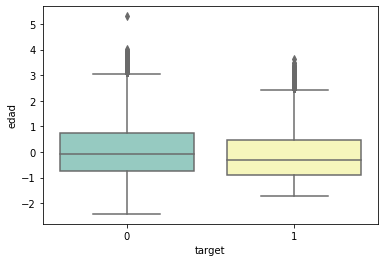

In [9]:
ax = sns.boxplot(x="target", y="edad", data=se_train, palette="Set3")

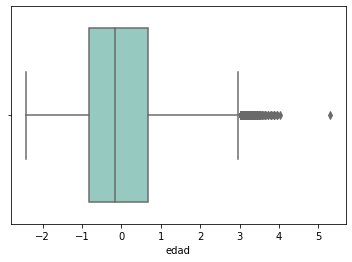

In [10]:
ax = sns.boxplot("edad", data=se_train, palette="Set3")

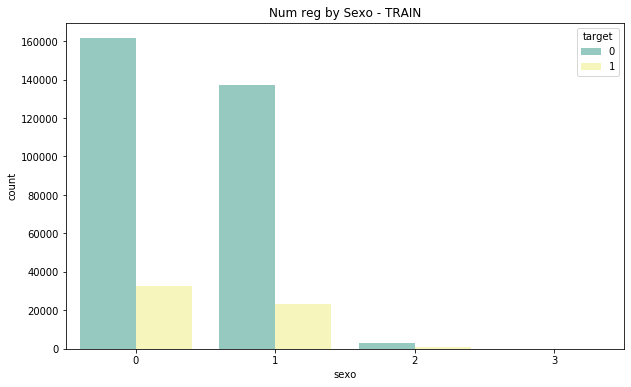

In [15]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="sexo", hue="target",linewidth=1.5, palette="Set3", data=se_train).set_title("Num reg by Sexo - TRAIN")
pass

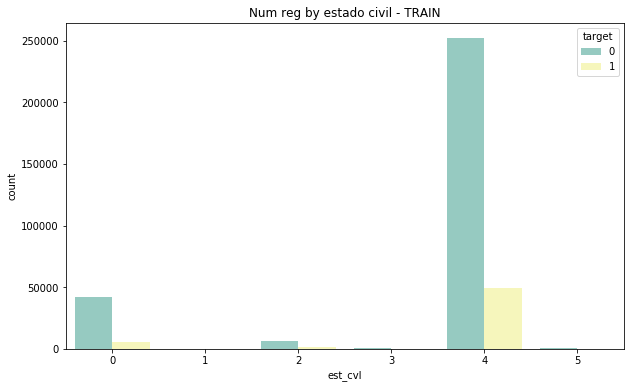

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="est_cvl", hue="target",linewidth=1.5, palette="Set3", data=se_train).set_title("Num reg by estado civil - TRAIN")
pass

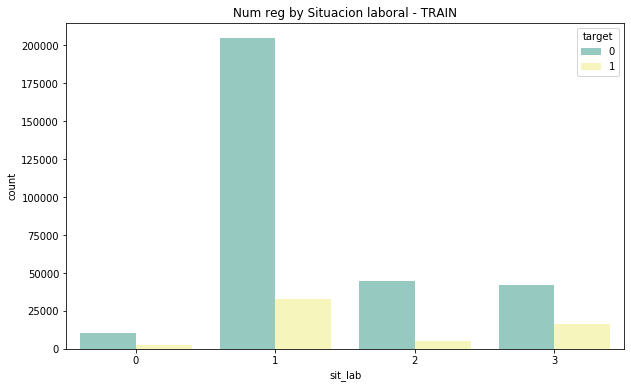

In [20]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="sit_lab", hue="target",linewidth=1.5, palette="Set3", data=se_train).set_title("Num reg by Situacion laboral - TRAIN")
pass

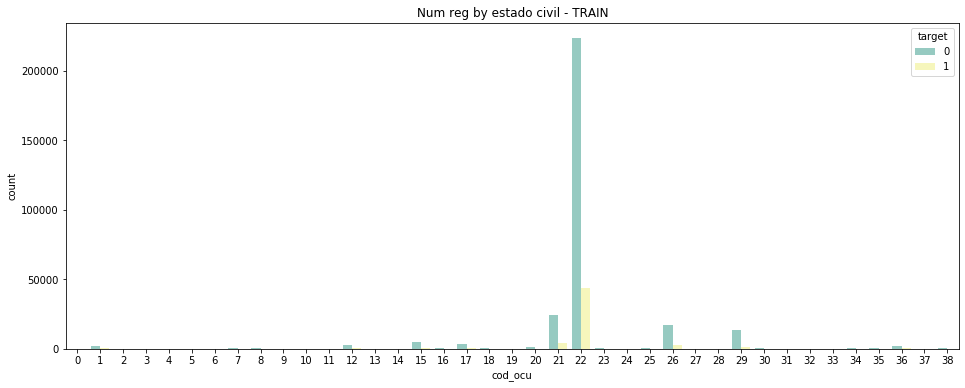

In [19]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="cod_ocu", hue="target",linewidth=1.5, palette="Set3", data=se_train).set_title("Num reg by Cod Ocupacion - TRAIN")
pass

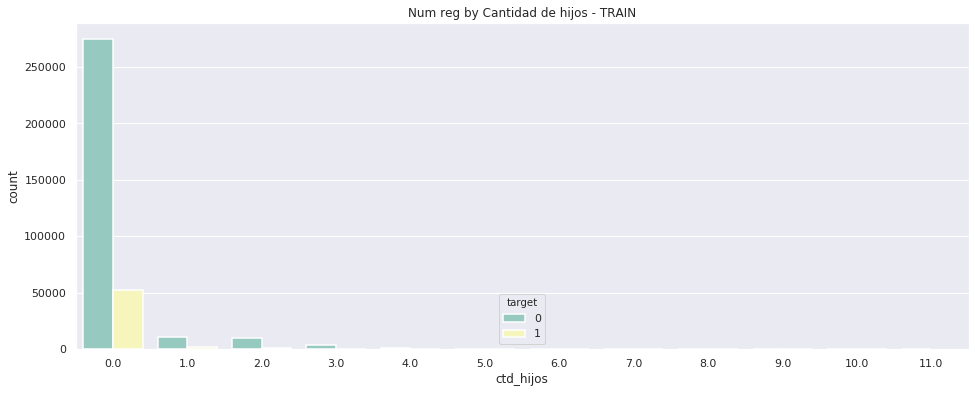

In [26]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="ctd_hijos", hue="target",linewidth=1.5, palette="Set3", data=se_train).set_title("Num reg by Cantidad de hijos - TRAIN")
pass

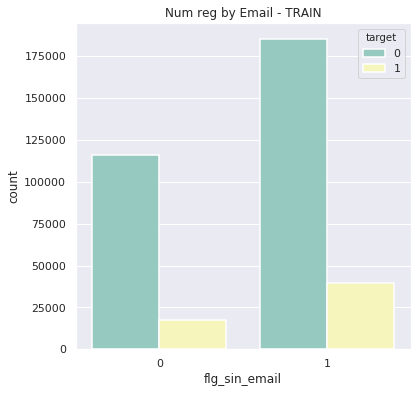

In [27]:
plt.figure(figsize=(6, 6))
ax = sns.countplot(x="flg_sin_email", hue="target",linewidth=1.5, palette="Set3", data=se_train).set_title("Num reg by Email - TRAIN")
pass

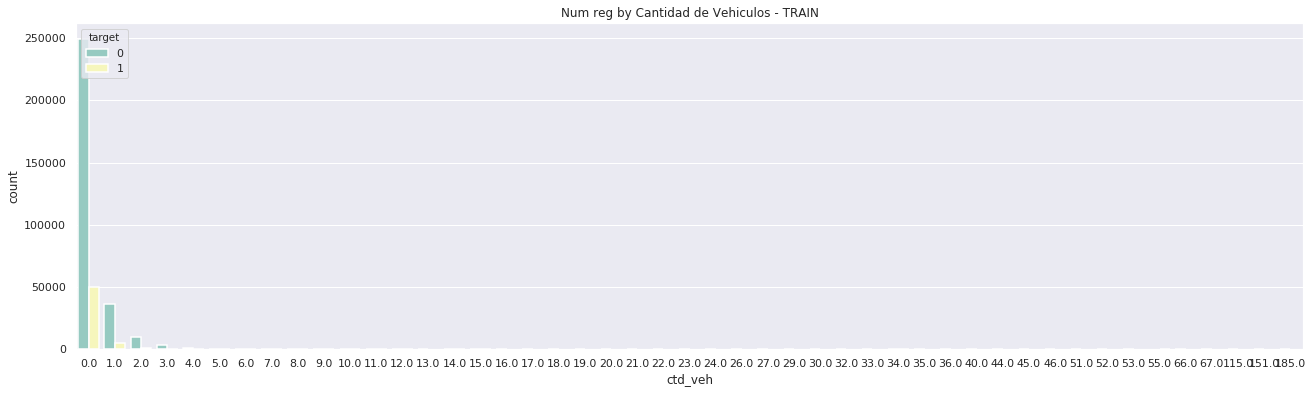

In [29]:
plt.figure(figsize=(22, 6))
ax = sns.countplot(x="ctd_veh", hue="target",linewidth=1.5, palette="Set3", data=se_train).set_title("Num reg by Cantidad de Vehiculos - TRAIN")
pass

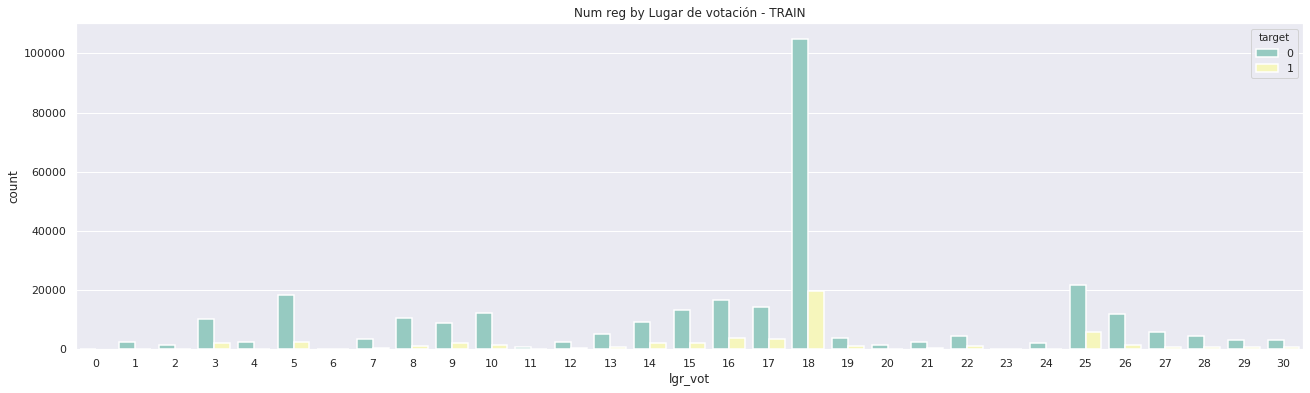

In [30]:
plt.figure(figsize=(22, 6))
ax = sns.countplot(x="lgr_vot", hue="target",linewidth=1.5, palette="Set3", data=se_train).set_title("Num reg by Lugar de votación - TRAIN")
pass

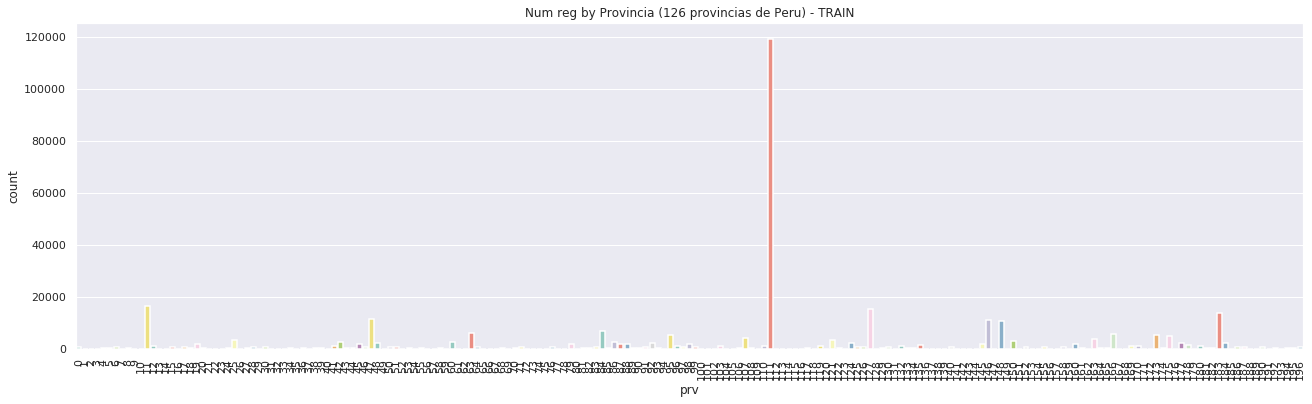

In [32]:
plt.figure(figsize=(22, 6))
ax = sns.countplot(x="prv",linewidth=1.5, palette="Set3", data=se_train).set_title("Num reg by Provincia (126 provincias de Peru) - TRAIN")
plt.xticks(rotation=90)
pass

+ En el Perú, una provincia es la unidad de subdivisión administrativa inferior a un departamento. Se hallan subdivididas en distritos. Cada provincia es gobernada civilmente por una municipalidad provincial encabezada por un alcalde quien dirige la política provincial y es elegido por sufragio universal cada cuatro años. Actualmente hay 196 provincias.
+ la mayoria de los casos corresponden a la provincia 110
+ El nombre de la provincia se puede llegar a obtener por medio del codigo ubigo


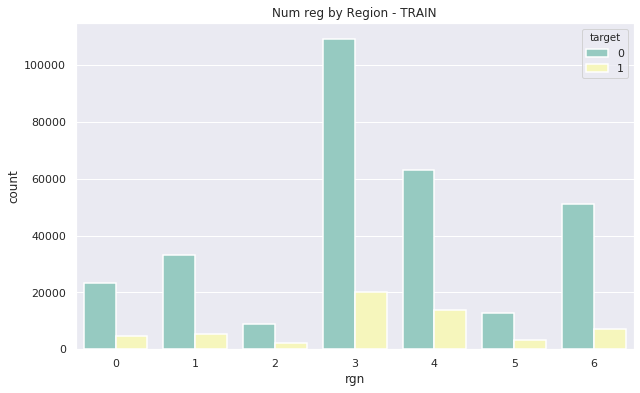

In [34]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="rgn", hue="target",linewidth=1.5, palette="Set3", data=se_train).set_title("Num reg by Region - TRAIN")
pass

Teoricamente Peru solo posee 3 regiones geograficas. 

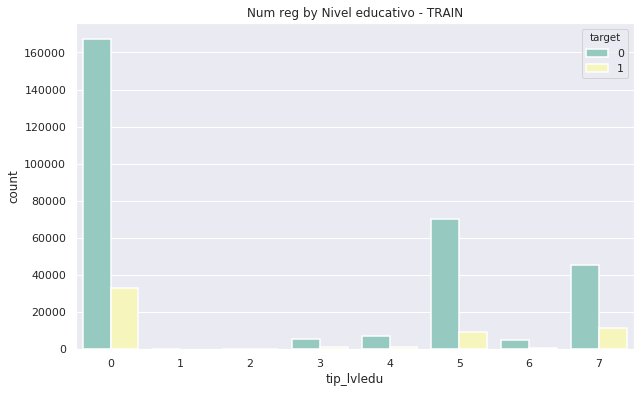

In [35]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="tip_lvledu", hue="target",linewidth=1.5, palette="Set3", data=se_train).set_title("Num reg by Nivel educativo - TRAIN")
pass

In [36]:
gc.collect()

127488

### SE_TEST
**se_[train|test].csv** : información socio-económica

+ edad: edad.
+ sexo: sexo.
+ est_cvl: estado civil.
+ sit_lab: situación laboral.
+ cod_ocu: código de ocupación.
+ ctd_hijos: cantidad de hijos.
+ flg_sin_email: tiene o no email.
+ ctd_veh: cantidad de vehículos.
+ cod_ubi: código ubigeo.
+ lgr_vot: lugar de votación.
+ prv: provincia.
+ dto: departamento.
+ rgn: region.
+ tip_lvledu: tipo de nivel educativo.


In [8]:
se_test = pd.read_csv("../../data/raw/se_test.csv").pipe(reduce_mem_usage)

In [9]:
se_test.shape

(396609, 15)

In [10]:
se_test = se_test[se_test.key_value.isin(rcc_test.key_value.unique().tolist())]

In [11]:
se_test.shape

(396609, 15)

In [12]:
se_test.head()

,key_value,edad,sexo,est_cvl,sit_lab,cod_ocu,ctd_hijos,flg_sin_email,ctd_veh,cod_ubi,lgr_vot,prv,dto,rgn,tip_lvledu
0,0,1.137034,0,4,2,29,0.0,0,0.0,0.043777,18,111,772,3,0
1,1,-1.513823,0,4,1,22,0.0,1,0.0,0.618486,25,127,949,5,7
2,2,-1.135129,0,4,1,22,0.0,0,0.0,0.043777,18,111,1296,3,5
3,3,0.606863,0,4,1,22,0.0,1,0.0,1.179965,9,148,170,2,5
4,4,-1.135129,0,4,1,21,0.0,1,0.0,0.952782,28,175,1487,6,0


In [13]:
se_test.describe().T

,count,mean,std,min,25%,50%,75%,max
key_value,396609.0,198326.778656,114505.796221,0.000000,99159.000000,198329.000000,297490.000000,396665.000000
edad,386975.0,-0.055241,1.003325,-2.119733,-0.907913,-0.226264,0.606863,4.242323
sexo,396609.0,0.467791,0.545948,0.000000,0.000000,0.000000,1.000000,3.000000
est_cvl,396609.0,3.416640,1.360263,0.000000,4.000000,4.000000,4.000000,5.000000
sit_lab,396609.0,1.261073,0.587718,0.000000,1.000000,1.000000,1.000000,3.000000
cod_ocu,396609.0,22.134026,3.395046,0.000000,22.000000,22.000000,22.000000,38.000000
ctd_hijos,396609.0,0.157021,0.608200,0.000000,0.000000,0.000000,0.000000,12.000000
flg_sin_email,396609.0,0.637913,0.480604,0.000000,0.000000,1.000000,1.000000,1.000000
ctd_veh,396609.0,0.234095,0.952346,0.000000,0.000000,0.000000,0.000000,251.000000
cod_ubi,385995.0,0.001966,1.022003,-1.549017,-0.407862,0.043470,0.051358,9.250945


In [14]:
print(se_test.nunique())

key_value        396609
edad                 81
sexo                  4
est_cvl               6
sit_lab               4
cod_ocu              39
ctd_hijos            13
flg_sin_email         2
ctd_veh              47
cod_ubi            2084
lgr_vot              31
prv                 197
dto                1667
rgn                   7
tip_lvledu            8
dtype: int64


In [15]:
print(se_test.isnull().sum())

key_value            0
edad              9634
sexo                 0
est_cvl              0
sit_lab              0
cod_ocu              0
ctd_hijos            0
flg_sin_email        0
ctd_veh              0
cod_ubi          10614
lgr_vot              0
prv                  0
dto                  0
rgn                  0
tip_lvledu           0
dtype: int64


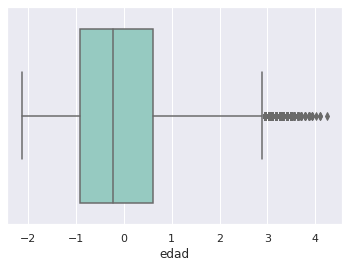

In [17]:
ax = sns.boxplot("edad", data=se_test, palette="Set3")

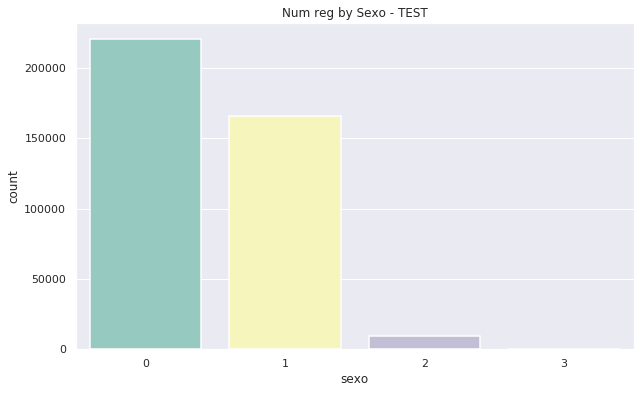

In [18]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="sexo", linewidth=1.5, palette="Set3", data=se_test).set_title("Num reg by Sexo - TEST")
pass

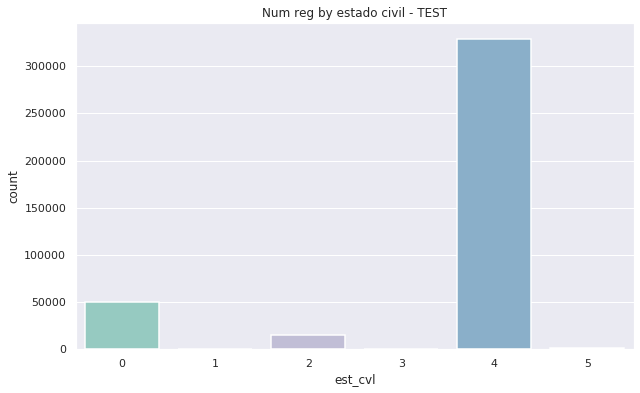

In [19]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="est_cvl", linewidth=1.5, palette="Set3", data=se_test).set_title("Num reg by estado civil - TEST")
pass

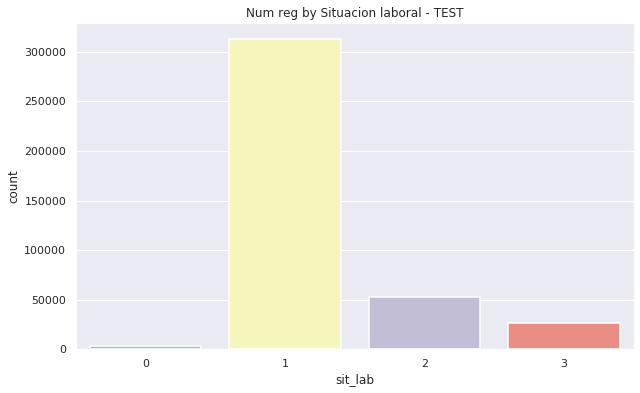

In [21]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="sit_lab", linewidth=1.5, palette="Set3", data=se_test).set_title("Num reg by Situacion laboral - TEST")
pass

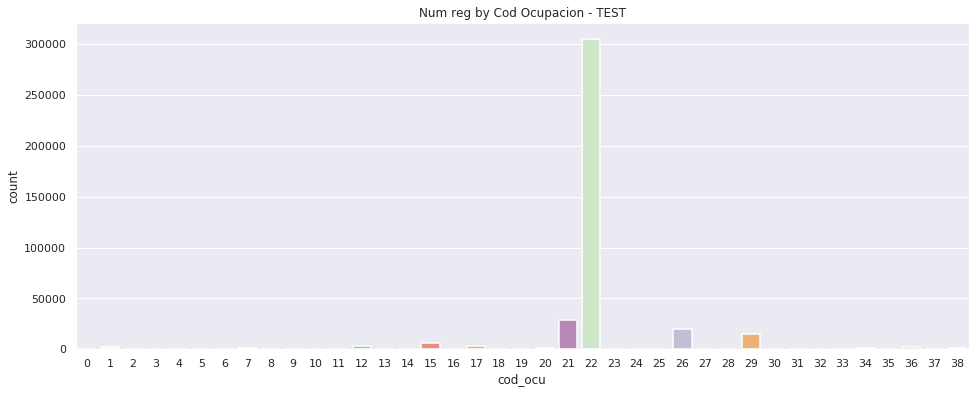

In [22]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="cod_ocu", linewidth=1.5, palette="Set3", data=se_test).set_title("Num reg by Cod Ocupacion - TEST")
pass

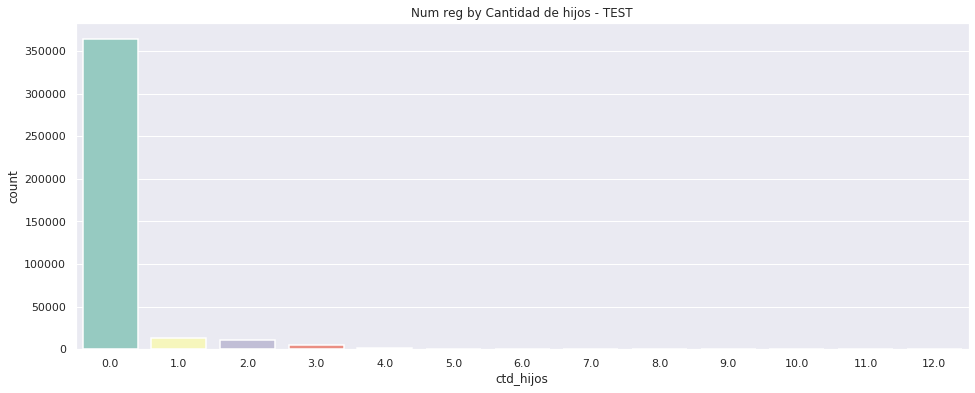

In [23]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="ctd_hijos", linewidth=1.5, palette="Set3", data=se_test).set_title("Num reg by Cantidad de hijos - TEST")
pass

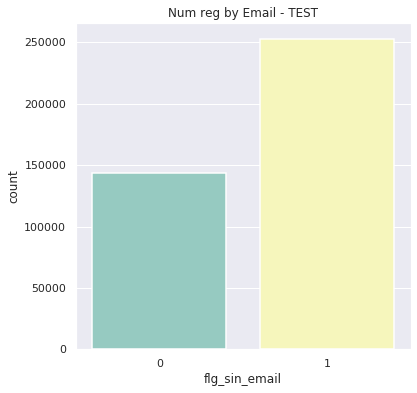

In [24]:
plt.figure(figsize=(6, 6))
ax = sns.countplot(x="flg_sin_email", linewidth=1.5, palette="Set3", data=se_test).set_title("Num reg by Email - TEST")
pass

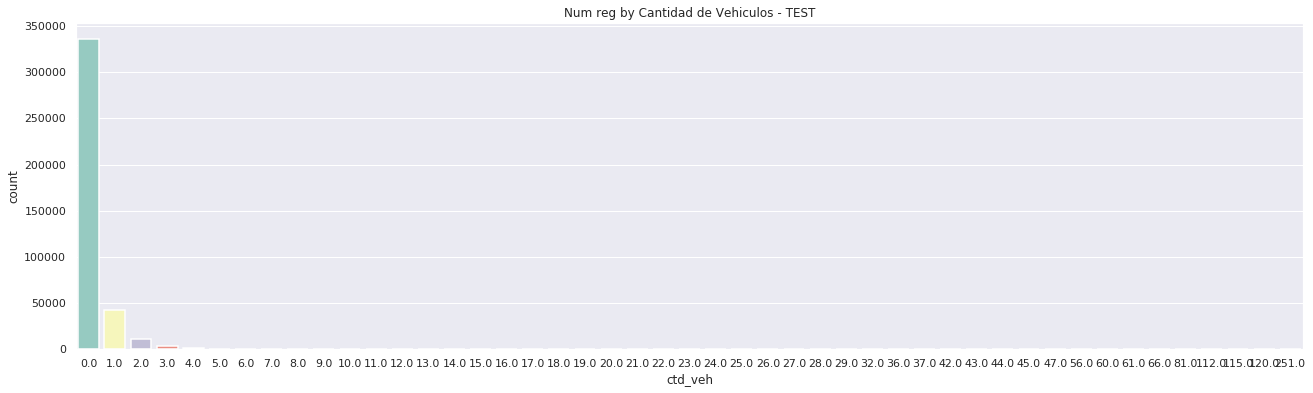

In [25]:
plt.figure(figsize=(22, 6))
ax = sns.countplot(x="ctd_veh", linewidth=1.5, palette="Set3", data=se_test).set_title("Num reg by Cantidad de Vehiculos - TEST")
pass

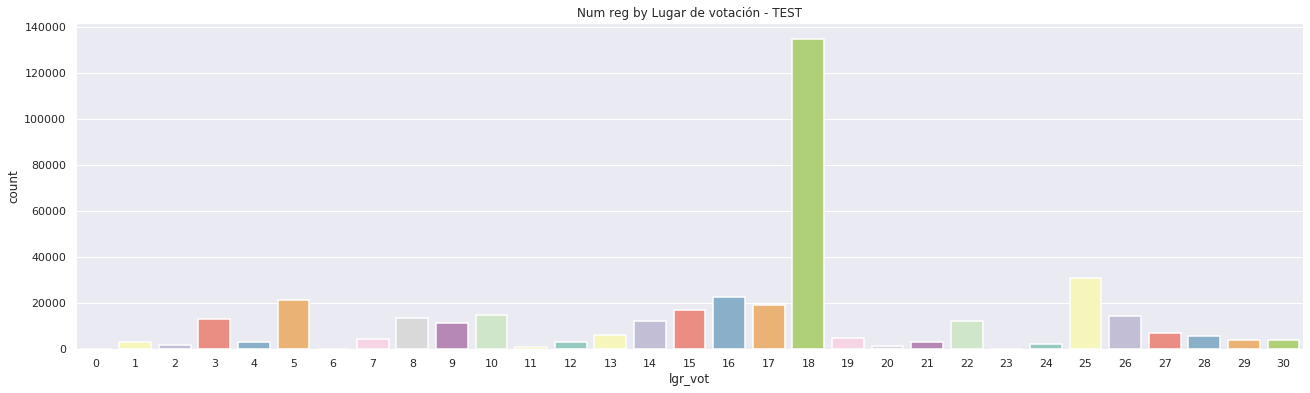

In [26]:
plt.figure(figsize=(22, 6))
ax = sns.countplot(x="lgr_vot", linewidth=1.5, palette="Set3", data=se_test).set_title("Num reg by Lugar de votación - TEST")
pass

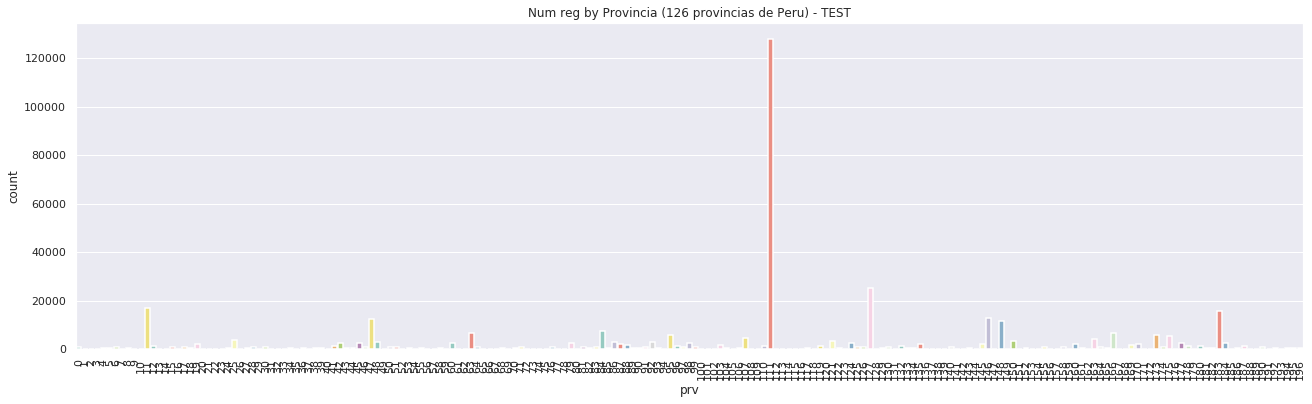

In [27]:
plt.figure(figsize=(22, 6))
ax = sns.countplot(x="prv",linewidth=1.5, palette="Set3", data=se_test).set_title("Num reg by Provincia (126 provincias de Peru) - TEST")
plt.xticks(rotation=90)
pass

+ En el Perú, una provincia es la unidad de subdivisión administrativa inferior a un departamento. Se hallan subdivididas en distritos. Cada provincia es gobernada civilmente por una municipalidad provincial encabezada por un alcalde quien dirige la política provincial y es elegido por sufragio universal cada cuatro años. Actualmente hay 196 provincias.
+ la mayoria de los casos corresponden a la provincia 110
+ El nombre de la provincia se puede llegar a obtener por medio del codigo ubigo


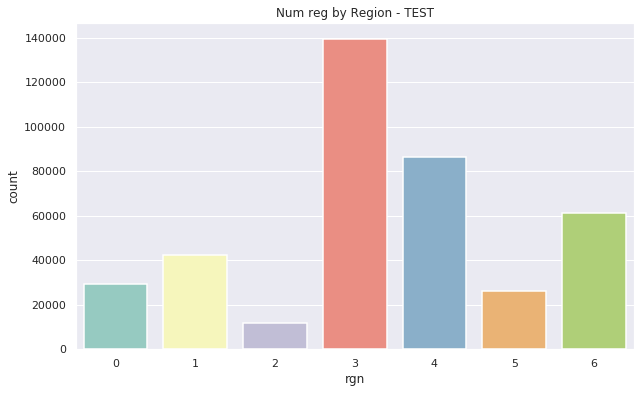

In [28]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="rgn", linewidth=1.5, palette="Set3", data=se_test).set_title("Num reg by Region - TEST")
pass

Teoricamente Peru solo posee 3 regiones geograficas. 

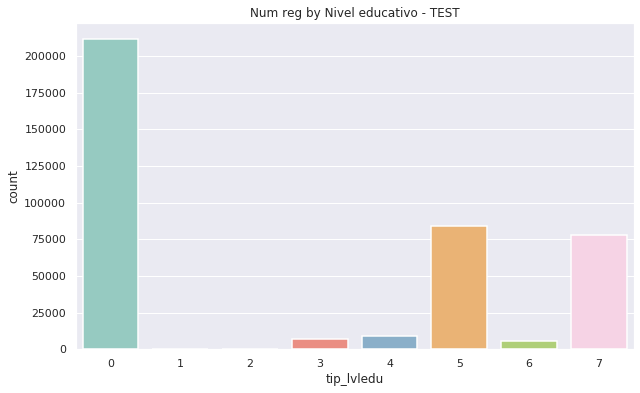

In [29]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="tip_lvledu", linewidth=1.5, palette="Set3", data=se_test).set_title("Num reg by Nivel educativo - TEST")
pass

In [30]:
gc.collect()

29027